## Monte Carlo simulation of a Merton jump-diffusion process

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pylab
from scipy.stats import norm, poisson
from numpy.fft import fft, ifft, ifftshift, fftshift

In [31]:
# X(t) = (muS-0.5*sigma^2)*t + sigma*W(t) + sum_{i=1}^{N(t)} Z_i

# Define parameters and time grid
npaths = 20000 # number of paths
T = 1 # time horizon
nsteps = 200 # number of time steps
dt = T/nsteps # time step
t = np.linspace(0,T,nsteps+1) # observation times
muS = 0.2 
sigma = 0.3 # model parameters of the diffusion part (GBM)
muJ = 0.05
sigmaJ = 0.1
lamb = 0.1 # model parameters of the jump part (NCPP)
S0 = 1 # initial stock price


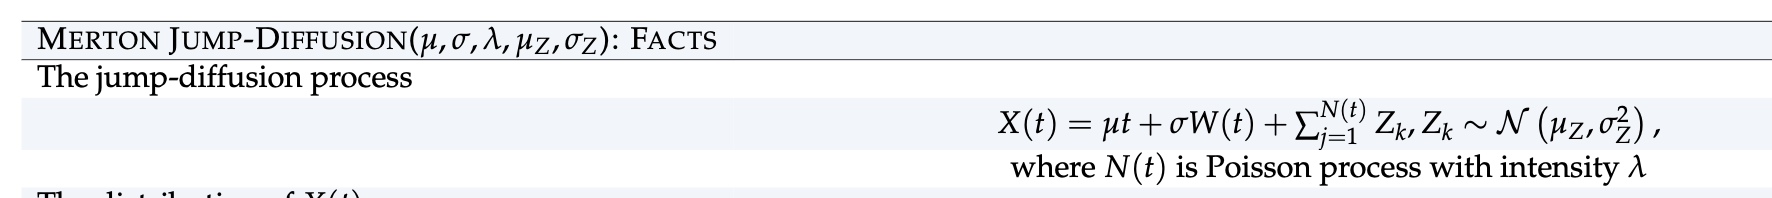

Text(0.5, 1.0, 'Paths of a Merton jump-diffusion process X = $\\mu$t + $\\sigma$W(t) + $\\Sigma_{i=1}^{N(t)}$ Z_i')

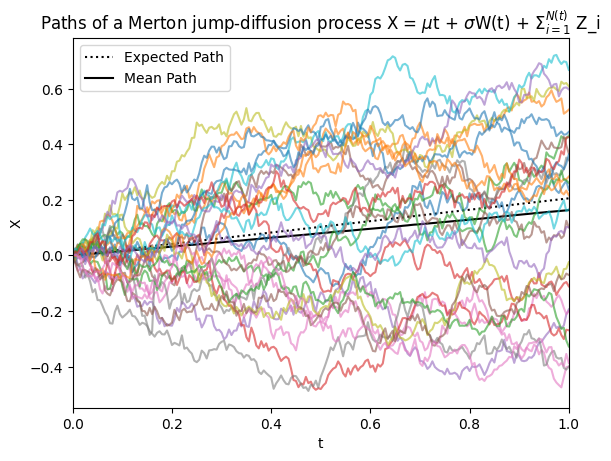

In [32]:
# Monte Carlo
# Compute the increments of the GBM
dW = (muS-0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.randn(nsteps,npaths)
# ABM - dW = mu*dt + sigma*np.sqrt(dt)*np.random.randn(nsteps,npaths)

# Compute the increments of the NCPP
dN = np.random.poisson(lamb*dt,(nsteps,npaths))
dJ = muJ*dN + sigmaJ*np.sqrt(dN)*np.random.randn(nsteps,npaths)

# Sum the increments of the ABM and the NCPP
dX = dW + dJ

# Accumulate the increments
X = np.vstack([np.zeros((1,npaths)),np.cumsum(dX,axis=0)])

# Stock price
S = S0*np.exp(X) #transform back to stock price (GBM)

## Expected, mean and sample path
plt.figure()
EX = (muS+lamb*muJ)*t # expected path
plt.plot(t,EX,'k:', label = 'Expected Path')
plt.plot(t,np.mean(X, axis=1), color='black',label='Mean Path')
plt.plot(t,X[:,::750], alpha=0.6)
plt.legend(loc=0)
plt.xlabel('t')
plt.ylabel('X')
plt.xlim([-0,T])
plt.title(r'Paths of a Merton jump-diffusion process X = $\mu$t + $\sigma$W(t) + $\Sigma_{i=1}^{N(t)}$ Z_i')

Text(0.5, 0, 'x')

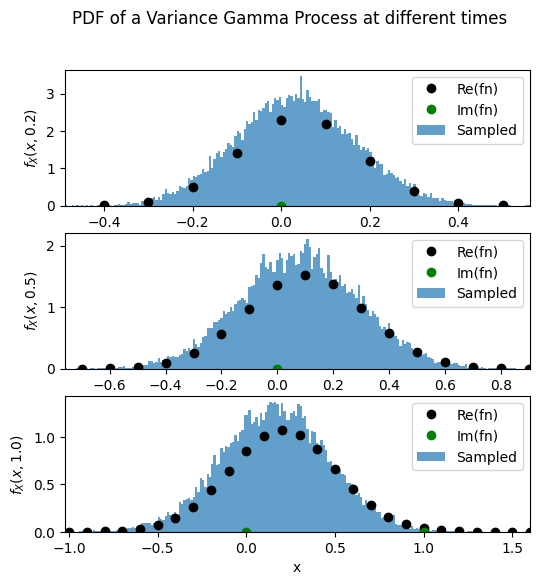

In [42]:
# FT Approx of Pdf using IFFT
N = 512
dx = 0.1
upperx = N * dx
x = dx * np.arange(-N/2, N/2)

# GRID IN FOURIER SPACE (Pulsation)
dxi = (2*np.pi)/(N*dx) #Grid step size in fourier space
upperx = N*dxi # Upper truncation limit in fourier space
xi = dxi * np.arange(-N/2, N/2)  # grid in Fourier space

fig, ax = plt.subplots(3,1, figsize=(6,6))
for i,time in enumerate([40,100,-1]):
    ax[i].hist(X[time,:],density=True,bins=nsteps, alpha=0.7)

    # Pulsation space: 
    char_func = np.exp(1j * muS * xi * t[time] - 0.5 * sigma**2 * xi**2 * t[time] + lamb * (np.exp(1j * xi * muJ - 0.5 * sigmaJ**2 * xi**2) - 1) * t[time])
    f_X = fftshift(fft(ifftshift(char_func))) / upperx
    ax[i].plot(x,np.real(f_X), 'ko', np.imag(f_X), 'go')

    ax[i].set_ylabel(f'$f_X(x, {t[time]:.1f})$')
    ax[i].legend(['Re(fn)', 'Im(fn)','Sampled'])
    ax[i].set_xlim(min(X[time,:]), max(X[time,:]))

plt.suptitle('PDF of a Variance Gamma Process at different times')
plt.xlabel('x')

Text(0.5, 1.0, 'Merton Jump Diffusion: Variance')

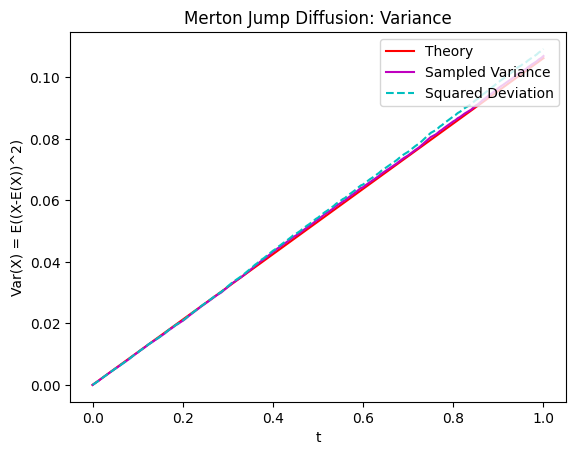

In [6]:
# Variance = mean square deviation
plt.figure()
plt.plot(t, (sigma**2 + lamb*(muJ**2+sigmaJ**2))*t, 'r', label='Theory') 
plt.plot(t, np.var(X, axis=1), 'm', label='Sampled Variance')
plt.plot(t, np.mean((X - EX[:, np.newaxis])**2, axis=1), 'c--', label='Squared Deviation')
plt.legend(loc='upper right')
plt.xlabel('t')
plt.ylabel('Var(X) = E((X-E(X))^2)')
plt.title('Merton Jump Diffusion: Variance')

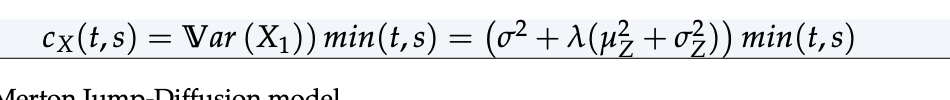

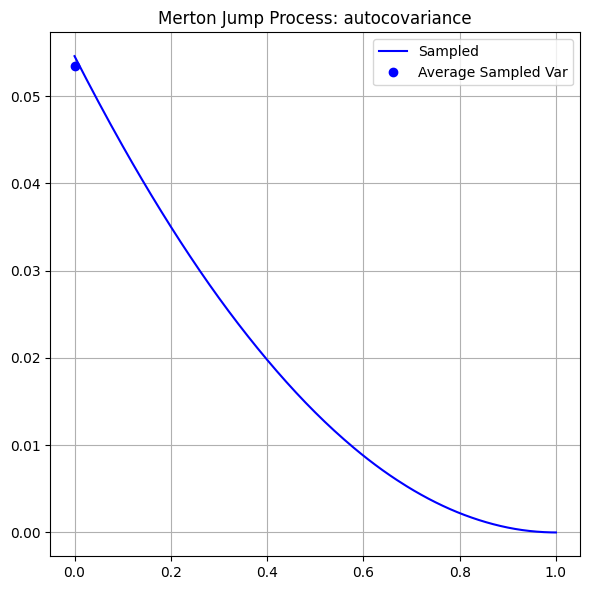

In [7]:
from scipy.signal import correlate
# Initialize the autocovariance array
C = np.zeros((npaths, 2 * nsteps+1))

# Calculate the autocovariance for each path
for i in range(npaths):
    deviation = X[:, i] - EX
    # Compute autocorrelation and normalize by the number of steps
    C[i, :] = correlate(deviation, deviation, mode='full') / nsteps
# Average over all paths
C = np.mean(C, axis=0)

plt.figure(figsize=(6, 6))
t = np.linspace(0, T, nsteps+1)

# Plot theoretical autocovariance - sigma^2 / (2 * alpha) * exp(-alpha * t)
# theo = (0.5*lamb*sigma**2*np.exp(2*mu+sigma**2)-np.exp(mu+0.5*sigma**2))*(np.exp(-lamb*t)-1) - GPT solution WRONG
# theo = (sigma**2 + lamb*(muJ**2+sigmaJ**2))*t
# plt.plot(t, theo, 'r', label='Theory') # WHAT IS s? It will always be smaller??

# Plot sampled autocovariance - plot second half since it's symmetric and the first half corresponds to negative lags
plt.plot(t, C[nsteps:], 'b', label='Sampled')
plt.plot(0, np.mean(np.var(X, axis=1)), 'bo', label='Average Sampled Var', linewidth=1.5) # average sampled variance

plt.legend(loc=0)
plt.title('Merton Jump Process: autocovariance')
plt.tight_layout()
plt.grid()

Text(0, 0.5, 'Density')

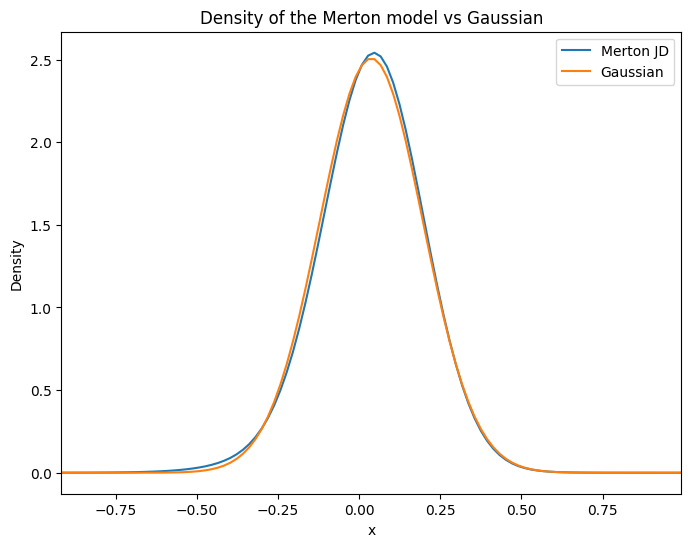

In [8]:
# Comparison to Normal Distribution
# Parameters
expiry = 0.25

# We assume we cannot have more than 30 jumps in the time frame
N = np.arange(0, 31)

# Mean and standard deviation to build the x-grid
meanJD = (muS + lamb * muJ) * expiry
sdJD = np.sqrt((sigma**2 + lamb * sigmaJ**2) * expiry)
xmin = meanJD - 6 * sdJD
xmax = meanJD + 6 * sdJD
xT = np.linspace(xmin, xmax, 100)

# 1. Compute weights
weights = poisson.pmf(N, lamb * expiry)

# 2. Truncate if the sum of weights reaches a threshold
Nmax = np.argmax(np.cumsum(weights) >= 0.99999999)

# 3. Mean and variance if there are j jumps
meanJ = muS * expiry + np.arange(0, Nmax+1) * muJ
varJ = sigma**2 * expiry + np.arange(0, Nmax+1) * sigmaJ**2

# 4. Build the density
gaussJD = np.zeros((Nmax + 1, len(xT)))
for j in range(Nmax + 1):
    gaussJD[j, :] = weights[j] * norm.pdf(xT, meanJ[j], np.sqrt(varJ[j]))

# 5. The density
pdfMerton = np.sum(gaussJD, axis=0)

plt.figure(figsize=(8, 6))
plt.plot(xT, pdfMerton, label='Merton JD')
plt.plot(xT, norm.pdf(xT, meanJD, sdJD), label='Gaussian')
plt.legend()
plt.xlim([xmin, xmax])
plt.title('Density of the Merton model vs Gaussian')
plt.xlabel('x')
plt.ylabel('Density')